# Poem Classification

## Data Importation and Exploration

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kaidonkennedy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kaidonkennedy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kaidonkennedy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
train_data = pd.read_csv('Poem_classification - train_data.csv')
test_data = pd.read_csv('Poem_classification - test_data.csv')

In [3]:
train_data.head(5)

,Genre,Poem
0,Music,NaN
1,Music,In the thick brushthey spend the...
2,Music,Storms are generous. ...
3,Music,—After Ana Mendieta Did you carry around the ...
4,Music,for Aja Sherrard at 20The portent may itself ...


In [4]:
test_data.head(5)

,Genre,Poem
0,Music,A woman walks by the bench I’m sitting onwith ...
1,Music,"Because I am a boy, the untouchability of beau..."
2,Music,"Because today we did not leave this world,We n..."
3,Music,"Big Bend has been here, been here. Shouldn’t i..."
4,Music,"I put shells there, along the lip of the road...."


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   841 non-null    object
 1   Poem    837 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB


In [6]:
train_data['Genre'].value_counts()

Genre
Music          239
Death          234
Environment    227
Affection      141
Name: count, dtype: int64

In [7]:
train_data.isnull().sum()

Genre    0
Poem     4
dtype: int64

In [8]:
#just remove the 4 null values
train_df = train_data.dropna()

In [9]:
train_df.isnull().sum()

Genre    0
Poem     0
dtype: int64

## Preprocessing

In [10]:
# clean text
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    words = nltk.word_tokenize(text)
    return words

In [11]:
#remove stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(words):
    return [word for word in words if word not in stop_words]

In [12]:
#lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

In [13]:
#Apply Preprocessing
def preprocess_poem(poem):
    words = clean_text(poem)
    words = remove_stopwords(words)
    words = lemmatize_words(words)
    return ' '.join(words)  # Join words back into a single string

In [14]:
train_df['cleaned_poem'] = train_df['Poem'].apply(preprocess_poem)

/var/folders/c7/symnjm6d69x6p3rtw2qvqmyc0000gn/T/ipykernel_16017/1431374668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cleaned_poem'] = train_df['Poem'].apply(preprocess_poem)


In [15]:
# Encoding
label_encoder = LabelEncoder()
train_df['genre_encoded'] = label_encoder.fit_transform(train_df['Genre'])

# Save the mapping for later use
category_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print(category_mapping)

{'Affection': 0, 'Death': 1, 'Environment': 2, 'Music': 3}


/var/folders/c7/symnjm6d69x6p3rtw2qvqmyc0000gn/T/ipykernel_16017/1316622839.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['genre_encoded'] = label_encoder.fit_transform(train_df['Genre'])


In [16]:
train_df.head(1)

,Genre,Poem,cleaned_poem,genre_encoded
1,Music,In the thick brushthey spend the...,thick brushthey spend hottest part day soaking...,3


In [17]:
# split the data
X = train_df['cleaned_poem']
y = train_df['genre_encoded']

# Use train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature extraction

### TF-IDF

In [18]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Top 5000 features

# Fit and transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(X_train_tfidf.shape)  # Check dimensions of the output

(669, 5000)


## Modeling

### Logistic regression model

In [19]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

In [20]:
# Train the model
model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [21]:
#Check scores
print(f'The training score is {model.score(X_train_tfidf, y_train)}')
print(f'The test score is {model.score(X_test_tfidf, y_test)}')

The training score is 0.9461883408071748
The test score is 0.44642857142857145


In [22]:
# Predict on the test set
y_pred = model.predict(X_test_tfidf)

In [23]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.45


In [24]:
# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

   Affection       0.30      0.36      0.33        22
       Death       0.39      0.38      0.38        45
 Environment       0.57      0.57      0.57        54
       Music       0.44      0.40      0.42        47

    accuracy                           0.45       168
   macro avg       0.42      0.43      0.43       168
weighted avg       0.45      0.45      0.45       168



In [25]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print it directly
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 8  3  5  6]
 [ 6 17  9 13]
 [ 8 10 31  5]
 [ 5 14  9 19]]


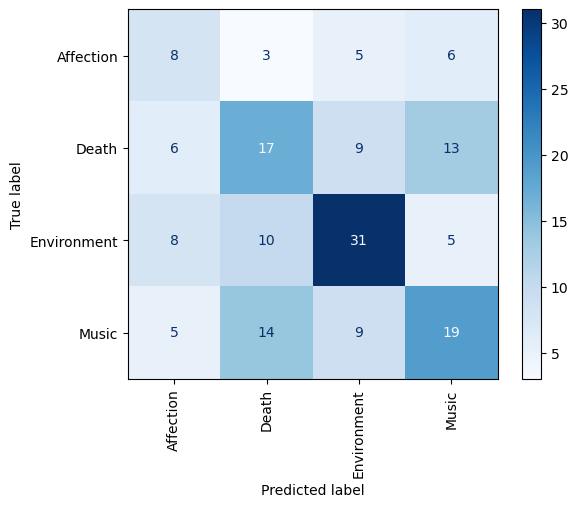

In [26]:
# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()

### SVC

In [27]:
# Initialize the SVC model with a linear kernel
svc_model = SVC(kernel='linear', class_weight='balanced', random_state=42)

In [28]:
# Train the model
svc_model.fit(X_train_tfidf, y_train)

SVC(class_weight='balanced', kernel='linear', random_state=42)

In [29]:
# Predict the labels for the test set
y_pred_svc = svc_model.predict(X_test_tfidf)

In [30]:
print(f'The training score is {svc_model.score(X_train_tfidf, y_train)}')
print(f'The test score is {svc_model.score(X_test_tfidf, y_test)}')

The training score is 0.9446935724962631
The test score is 0.43452380952380953


In [31]:
# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svc, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

   Affection       0.27      0.32      0.29        22
       Death       0.38      0.40      0.39        45
 Environment       0.59      0.54      0.56        54
       Music       0.41      0.40      0.41        47

    accuracy                           0.43       168
   macro avg       0.41      0.41      0.41       168
weighted avg       0.44      0.43      0.44       168



In [32]:
# Generate confusion matrix
svc_cm = confusion_matrix(y_test, y_pred_svc)

# Print it directly
print("Confusion Matrix:")
print(svc_cm)

Confusion Matrix:
[[ 7  3  6  6]
 [ 6 18  6 15]
 [ 8 11 29  6]
 [ 5 15  8 19]]


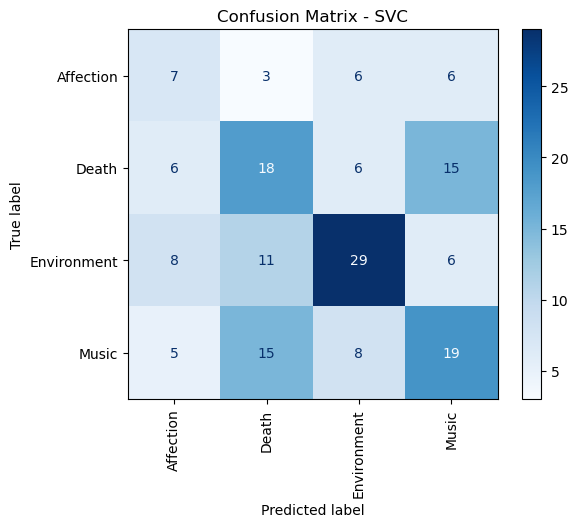

In [33]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(
    svc_model, X_test_tfidf, y_test, display_labels=label_encoder.classes_, cmap='Blues', xticks_rotation='vertical'
)
plt.title("Confusion Matrix - SVC")
plt.show()

### Random Forest Model

In [34]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=400,  # Number of trees in the forest
    class_weight='balanced',  # Handle class imbalance
    random_state=42  # Ensure reproducibility
)

In [35]:
# Train the model
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=400,
                       random_state=42)

In [36]:
print(f'The training score is {rf_model.score(X_train_tfidf, y_train)}')
print(f'The test score is {rf_model.score(X_test_tfidf, y_test)}')

The training score is 0.9491778774289985
The test score is 0.39880952380952384


In [37]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test_tfidf)

In [38]:
# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

   Affection       0.21      0.18      0.20        22
       Death       0.38      0.56      0.45        45
 Environment       0.49      0.43      0.46        54
       Music       0.42      0.32      0.36        47

    accuracy                           0.40       168
   macro avg       0.37      0.37      0.37       168
weighted avg       0.40      0.40      0.39       168



In [39]:
rf_cm = confusion_matrix(y_test, y_pred_rf)

# Print it directly
print("Confusion Matrix:")
print(rf_cm)

Confusion Matrix:
[[ 4  9  5  4]
 [ 4 25  8  8]
 [ 7 15 23  9]
 [ 4 17 11 15]]


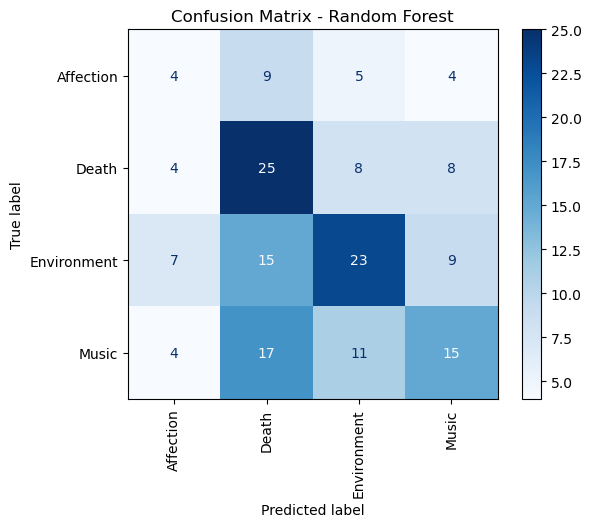

In [40]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(
    rf_model, X_test_tfidf, y_test, display_labels=label_encoder.classes_, cmap='Blues', xticks_rotation='vertical'
)
plt.title("Confusion Matrix - Random Forest")
plt.show()

## Fine tuning a pretrained model

### tokenize the data

In [41]:
from datasets import Dataset
# Convert your data to a Hugging Face Dataset
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

# Create Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [42]:
from transformers import BertTokenizer

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/669 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

### Load pretrained bert model

In [43]:
from transformers import BertForSequenceClassification

# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
!pip install "transformers[torch]"
!pip install accelerate

### Define training arguments

In [45]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Define trainer

In [46]:
from transformers import Trainer

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

### Train and evaluate model

In [48]:
trainer.train() h

SyntaxError: invalid syntax (1399830442.py, line 1)

In [ ]:
# Evaluate performance
metrics = trainer.evaluate()
print(metrics)

In [ ]:
import torch

# Prepare a sample
sample_text = "This is an example poem about nature."
inputs = tokenizer(sample_text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

print(f"Predicted class: {label_encoder.inverse_transform([predicted_class])[0]}")

In [ ]:
model.save_pretrained("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")